# Chest X-Ray Images (Pneumonia)
Build a chest X-ray classifier that 

In [1]:
# Essential Imports
import tensorflow as tf
from tensorflow import keras as k
from PIL import Image as img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
print(tf.__version__)
print(k.__version__)

2.4.0-dev20200812
2.4.0


# Confirm Data Location
First, one must install the data needed to train the model. The data is downloaded from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download) as part of the Chest X-Ray Images (Pneumonia) competition.

Below, the installation of the data is in a directory of another HHD labelled `A:`. Then, I simply added a test to ensure that the directories exist and that there's data present in each one.

In [2]:
# File paths
train_data_normal_directory_path = "A:/Downloads/archive/chest_xray/train/NORMAL/"
train_data_pneumonia_directory_path = "A:/Downloads/archive/chest_xray/train/NORMAL/"
test_data_normal_directory_path = "A:/Downloads/archive/chest_xray/test/PNEUMONIA/"
test_data_pneumonia_directory_path = "A:/Downloads/archive/chest_xray/test/PNEUMONIA/"
validation_data_normal_directory_path = "A:/Downloads/archive/chest_xray/val/NORMAL/"
validation_data_pneumonia_directory_path = "A:/Downloads/archive/chest_xray/val/PNEUMONIA/"
data_directory_path = [train_data_normal_directory_path,
                        train_data_pneumonia_directory_path,
                        test_data_normal_directory_path,
                        test_data_pneumonia_directory_path,
                        validation_data_normal_directory_path,
                        validation_data_pneumonia_directory_path]

# Check file paths
for directory in data_directory_path:
    # If directories exist
    if os.path.isdir(directory):
        print(f"{directory} does exist!")
    # If directories have data present
    if os.listdir(directory):
        print(f"{directory} contains data!\n")


A:/Downloads/archive/chest_xray/train/NORMAL/ does exist!
A:/Downloads/archive/chest_xray/train/NORMAL/ contains data!

A:/Downloads/archive/chest_xray/train/NORMAL/ does exist!
A:/Downloads/archive/chest_xray/train/NORMAL/ contains data!

A:/Downloads/archive/chest_xray/test/PNEUMONIA/ does exist!
A:/Downloads/archive/chest_xray/test/PNEUMONIA/ contains data!

A:/Downloads/archive/chest_xray/test/PNEUMONIA/ does exist!
A:/Downloads/archive/chest_xray/test/PNEUMONIA/ contains data!

A:/Downloads/archive/chest_xray/val/NORMAL/ does exist!
A:/Downloads/archive/chest_xray/val/NORMAL/ contains data!

A:/Downloads/archive/chest_xray/val/PNEUMONIA/ does exist!
A:/Downloads/archive/chest_xray/val/PNEUMONIA/ contains data!



# Preprocess the data

We want to load up the image data into Numpy arrays. We would want to store the data into 

In [11]:
# Load up test data
train_images = None
test_images = None
val_images = None

# Function for loading images into numpy arrays and returning them as a list
def loadImages(image_directory = None,
               list_images = [],
               list_image_labels = []):
    '''
    Load Images
    @description: Converts and loads image data (jpeg) into Numpy arrays, retaining image names as labels. 
    @param: image_directory (STRING). Image directory location
    @param: list_images (LIST). Numpy image list
    @param: list_image_labels (LIST). String image labels
    @returns: Tuple
    '''
    # Get image list
    for image in os.listdir(image_directory):
        # From the image, convert it into an Numpy array and retain its labelling
        list_images.append(np.asarray(img.open(f"{image_directory}\{image}")))
        list_image_labels.append(re.split("\.",image)[0])
    return (list_images, list_image_labels)

train_images_normal = loadImages(train_data_normal_directory_path)
train_images_pneumonia = loadImages(train_data_pneumonia_directory_path)
test_images_normal = loadImages(test_data_normal_directory_path)
test_images_pneumonia = loadImages(test_data_pneumonia_directory_path)

Checking the data, both the numpy and image names are retained as tupled lists. Below, we can view the converted numpy array as an image!

In [32]:
# Image name
print(train_images_normal[1][0])
# Image numpy conversion
print(train_images_normal[0][0])
# Image numpy array size
print(train_images_normal[0][0].shape)

IM-0115-0001
[[0.00033833 0.00036909 0.00036909 ... 0.00147636 0.0014456  0.00143022]
 [0.00035371 0.00036909 0.00036909 ... 0.00149173 0.0014456  0.00141484]
 [0.00036909 0.00036909 0.00035371 ... 0.00152249 0.00147636 0.0014456 ]
 ...
 [0.00075356 0.00076894 0.00073818 ... 0.00183007 0.00183007 0.00183007]
 [0.00076894 0.00079969 0.00081507 ... 0.00189158 0.00190696 0.00189158]
 [0.00079969 0.00081507 0.00083045 ... 0.00198385 0.00196847 0.00195309]]
(1858, 2090)


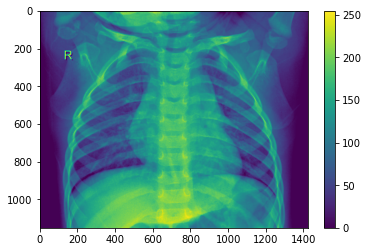

In [33]:
# Taking a look at the first encoded digit, it kinda looks like a '5'
plt.figure()
plt.imshow(train_images_normal[0][0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255, the max digit color value for an image. It's important that the training set and the testing set be preprocessed in the same way. although it is a bit overkill in this case as all jpegs are encoded up to amd limited to 255.

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

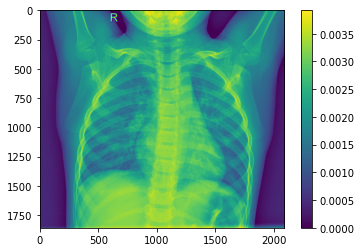

In [25]:
# Convert pixel values into an inclusive range of 0 to 1 for optimized processing
train_images_normal[0][0] = train_images_normal[0][0] / 255.0

# Now let's take a look!
plt.figure()
plt.imshow(train_images_normal[0][0])
plt.colorbar()
plt.grid(False)
plt.show()

As you can see, normalizing the data does not change the colouration. It only alters what the new digit colour value is.

# Create and Train the model

**ATTENTION**: we will test the model *without* normalizing the data.

Before we build and create the model, we have to determine the optimal feature size (i.e. the max amount of rows and columns based on image size). We must find the maximum and minimum image dimensions from the collected dataset.